# Reading 1D ecRad Output File. Test 1 Analysis. LogScale Colorbars

### Version 6 (alternative): 2024-07-16

* Test 1: Cloud Temperature - Altitude

* Colorbar with SymLog

* This version includes the $q_{i}$ correction and np.gradient for CRH calculation.

* Fixed parameters:
    1. Radiative Transfer Model: ecRad.
    1. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
    2. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
    3. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
    4. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
    5. No gases and aerosols.
    6. No liquid water.
    7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).
    8. Solvers: Tripleclouds

* Variable parameters:
    1. Macro: Position-Altitude-Temperature from 236 K to 200 K for cloud middle level.
    2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
    3. Macro: Ice Water Path (IWP) = 30 $g/m^2$ (Around Anvil Cirrus IWP typical value (Sokol & Hartmann 2020)):

        $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz} \;=\; 30\;\frac{g}{m^2}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

        where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/kg)$ times the density $\rho(z)$:

        $$\Rightarrow\;q_i = \frac{30\;g/m^2}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
    4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
    5. Ice Optical Schemes:

        5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).

        5.2 Yi et al. 2013 (2O).

        5.3 Baran et al. 2016 (3O).

        5.4 Baran et al. 2014 (4O).

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for opt in range(1,5):
    file = 'output_1D_matrix_height_'+str(opt)+'O1S_v6.nc'
    globals()['ecrad_out_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Tropical Profile (to get temperature profile)

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_11997/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_1O1S.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Store this in a function:

Cloud-radiative Heating (CRH) rate in $K\;d^{-1}$ for each spectral component $i$ (SW and LW):

$$CRH_{i} \;=\; - \frac{g_0}{C_P}\frac{\partial }{\partial P}(CRE_{i})\;\;\frac{K}{s}\times\;86400\;\frac{s}{d}$$

where $g_0$ is the standard gravity acceleration ($9.8\;ms^{-2}$), $C_P$ is the specific heat capacity of dry air ($1080\;J kg^{-1} K^{-1}$) and $CRE_{i}$ is the Cloud Radiative Effect for each spectral component $i$ (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where $F^{NET}$ is the NET irradiance or flux ($Wm^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

The sign in the CRH equation is because of the definition of the outgoing fluxes as positive (Be carefult with this).

In [6]:
tempi = ecrad_out_1O1S.sizes['column']     # Temperature Levels
profi = ecrad_out_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

## Heating rates matrices [K day-1]:
H_lw  = np.zeros((4, tempi, profi))
H_sw  = np.zeros((4, tempi, profi))
H_net = np.zeros((4, tempi, profi))

## Matrices for plotting:
H_sw_plot  = np.zeros((4, profi, tempi))
H_lw_plot  = np.zeros((4, profi, tempi))
H_net_plot = np.zeros((4, profi, tempi))

for opt in range(1,5): # per optical scheme
    ecrad_out = eval('ecrad_out_'+str(opt)+'O1S')
    for i in range(tempi):
        pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

        # Net Fluxes [W m-2]
        lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
        lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
        sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
        sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

        # Cloud Radiative Effect [W m-2]
        lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
        sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

        # The sign is because of the definition of Outgoing fluxes as positive:
        # By using the diff function:
        #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
        #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
        # By using the gradient function:
        H_lw[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
        H_sw[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

    H_net[opt-1,:,:] = H_lw[opt-1,:,:] + H_sw[opt-1,:,:]

    # For plotting:
    H_sw_plot[opt-1,:,:]  = np.transpose(H_sw[opt-1,:,:])
    H_lw_plot[opt-1,:,:]  = np.transpose(H_lw[opt-1,:,:])
    H_net_plot[opt-1,:,:] = np.transpose(H_net[opt-1,:,:])

In [2]:
ecrad_out_1O1S

NameError: name 'ecrad_out_1O1S' is not defined

## Figure for SM:

#### Plotting CRH Matrix

In [7]:
print(H_lw_plot.max())
print(H_sw_plot.max())
print(H_net_plot.max())
print(H_lw_plot.min())
print(H_sw_plot.min())
print(H_net_plot.min())

59.23353455921734
13.675190194695409
64.0160049465448
-9.994865460976017
-0.7029270930259816
-4.732501609238186


For SymLogNorm:

In [282]:
MaxMax = max([H_lw_plot.max(), H_sw_plot.max(), H_net_plot.max(), 
              abs(H_lw_plot.min()), abs(H_sw_plot.min()), abs(H_net_plot.min())])

Store this in a function:

In [291]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = 1
    linscale  = .1
    #list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

Max and min lines for each case:

In [14]:
input_dir  = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
input_file = 'input_1D_matrix_height_v6.nc'

In [293]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((4, 2)) # min and max
lw_ranges  = np.zeros((4, 2))
net_ranges = np.zeros((4, 2))
for opt in range(4):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_plot')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_plot')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


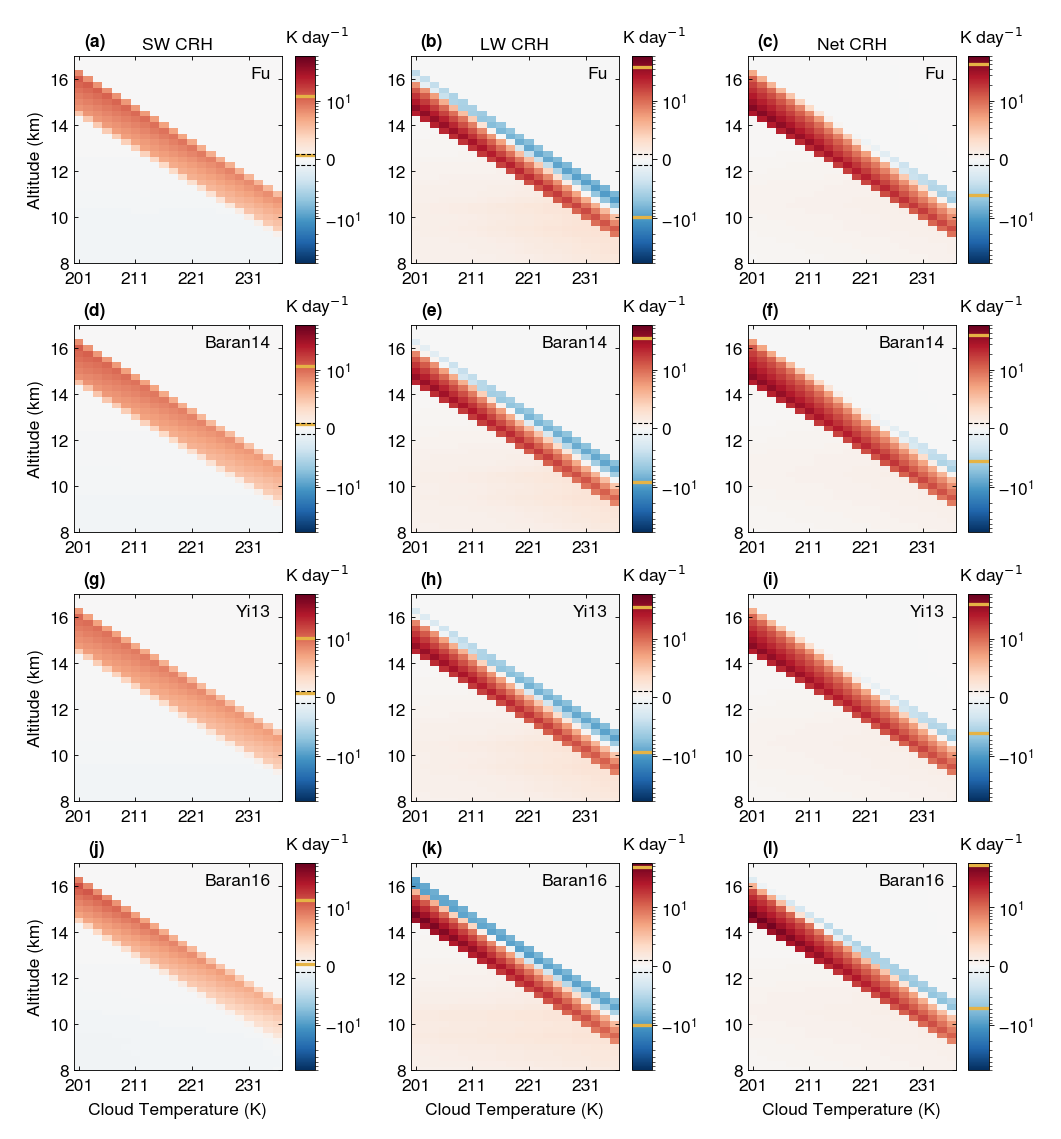

In [296]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 14.5 # inches
flength  = 13.5 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.06, left = 0.07, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
labelpad  = -40

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016
for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_net_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)

# AXIS PARAMETERS
# Y Axis: altitude tickLabels are rounded for visualization:
yticks      = np.arange(0, H.shape[2]+1, 8) # altitude tick labels
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch          = ['Fu', 'Yi13', 'Baran16', 'Baran14']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows):
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Cloud Temperature (K)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
        ax[opt, j].text(0.95, 0.95, OptSch[sch],
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')

        ax[opt, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
plt.savefig(out_dir+'crh_test1_S4_v6alt.pdf', dpi=500)

## Figure 1 in paper:

Fu scheme is shown as the example:

In [297]:
print(H_lw_plot[0].max())
print(H_sw_plot[0].max())
print(H_plot[0].max())
print(H_lw_plot[0].min())
print(H_sw_plot[0].min())
print(H_plot[0].min())

43.2017569093656
12.447910444216078
49.12167660020339
-9.659617131257649
-0.5547093910659702
-3.6042830474282166


For SymLogNorm:

In [298]:
MaxMax = max([H_lw_plot[0].max(), H_sw_plot[0].max(), H_net_plot[0].max(),
              abs(H_lw_plot[0].min()), abs(H_sw_plot[0].min()), abs(H_net_plot[0].min())])

Store this in a function:

In [300]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = 1
    linscale  = .1
    #list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

<IPython.core.display.Javascript object>


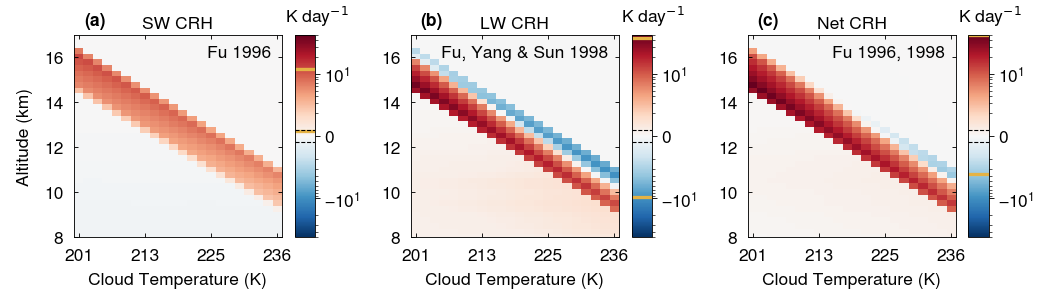

In [306]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
flength  = 13.5 # inches
fheigth  = 3.8 # inches

rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.88, bottom = 0.2, left = 0.07, right = 0.95, 
                    hspace = .3, wspace = .3)

# Shortwave Heating Rate
im = ax[0].imshow(H_sw_plot[0], cmap = 'RdBu_r', aspect = 'auto',
                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                           vmin = vmin, vmax = vmax)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
cbar.ax.axhline(sw_ranges[0, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(sw_ranges[0, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
cbar.ax.tick_params(which = 'minor', length = 2.5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[0].set_title('SW CRH', color = 'black',
                fontsize = fontsize, fontname = fontname)

# Longwave Heating Rate
im = ax[1].imshow(H_lw_plot[0], cmap = 'RdBu_r', aspect = 'auto', 
                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                           vmin = vmin, vmax = vmax)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
cbar.ax.axhline(lw_ranges[0, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(lw_ranges[0, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
cbar.ax.tick_params(which = 'minor', length = 2.5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[1].set_title('LW CRH', color = 'black',
                fontsize = fontsize, fontname = fontname)

# Heating Rate
im = ax[2].imshow(H_plot[0], cmap = 'RdBu_r', aspect = 'auto',
                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                           vmin = vmin, vmax = vmax)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
cbar.ax.axhline(net_ranges[0, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(net_ranges[0, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
cbar.ax.tick_params(which = 'minor', length = 2.5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[2].set_title('Net CRH', color ='black',
                fontsize = fontsize, fontname = fontname)


# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for j in range(columns):
    # Horizontal Lines:
    #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    ax[j].set_xlabel(r'Cloud Temperature (K)', 
                     fontsize = fontsize, fontname = fontname,
                     color ='black', labelpad = 7.5)
    ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                      size = 4, direction = 'in', top = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_xticklabels():
        tick.set_fontname(fontname)
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(xticklabels) #[::-1]
    ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                      size = 4, direction = 'in', right = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_yticklabels():
        tick.set_fontname(fontname)
    ax[j].set_yticks(yticks)
    ax[j].set_yticklabels(yticklabels)
    if j == 0:
        ax[j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 10)
        ax[j].text(0.95, 0.95, OptSch_sw[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    if j == 1:
        ax[j].text(0.95, 0.95, OptSch_lw[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    if j == 2:
        ax[j].text(0.95, 0.95, OptSch[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    ax[j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
    # Panel letters:
    ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
               ha = 'right', va = 'top', transform = ax[j].transAxes,
               fontsize = fontsize, fontname = fontname, color = 'black')
    panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
plt.savefig(out_dir+'crh_test1_Fu_F1_v6alt.pdf', dpi=500)

## Figure 2 in paper (CRH interscheme difference):

In [8]:
# Shortwave:
H_sw_diff_plot    = np.zeros((3, profi, tempi))
H_sw_diff_plot[0] = H_sw_plot[1] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[2] - H_sw_plot[0] # Baran2016 - Fu
H_sw_diff_plot[2] = H_sw_plot[3] - H_sw_plot[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot    = np.zeros((3, profi, tempi))
H_lw_diff_plot[0] = H_lw_plot[1] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[2] - H_lw_plot[0] # Baran2016 - Fu
H_lw_diff_plot[2] = H_lw_plot[3] - H_lw_plot[0] # Baran2014 - Fu

# Net:
H_net_diff_plot    = np.zeros((3, profi, tempi))
H_net_diff_plot[0] = H_net_plot[1] - H_net_plot[0] # Yi - Fu
H_net_diff_plot[1] = H_net_plot[2] - H_net_plot[0] # Baran - Fu
H_net_diff_plot[2] = H_net_plot[3] - H_net_plot[0] # Baran - Fu

In [9]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot[0].max())
print('Yi - Fu min: ',H_sw_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_sw_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_sw_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_sw_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_sw_diff_plot[2].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot[0].max())
print('Yi - Fu min: ',H_lw_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_lw_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_lw_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_lw_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_lw_diff_plot[2].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_net_diff_plot[0].max())
print('Yi - Fu min: ',H_net_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_net_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_net_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_net_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_net_diff_plot[2].min())

Shortwave CRH Differences:
Yi - Fu max:  0.0935911711937139
Yi - Fu min:  -2.2909030975768143
Baran2016 - Fu max:  1.2272797504793314
Baran2016 - Fu min:  -2.5182521355888134
Baran2014 - Fu max:  0.35372405159642817
Baran2014 - Fu min:  -1.0835578615863497

Longwave CRH Differences:
Yi - Fu max:  1.4894992746837898
Yi - Fu min:  -3.4925222642901943
Baran2016 - Fu max:  16.03177764985174
Baran2016 - Fu min:  -8.785502996119627
Baran2014 - Fu max:  1.8836622346641647
Baran2014 - Fu min:  -3.6091088881344433

Net CRH Differences:
Yi - Fu max:  0.08126055405244026
Yi - Fu min:  -4.076007015102519
Baran2016 - Fu max:  14.894328346341403
Baran2016 - Fu min:  -7.558223245640296
Baran2014 - Fu max:  1.3728995437601217
Baran2014 - Fu min:  -3.2875242808329332


For SymLogNorm:

In [10]:
MaxMax = max([H_sw_diff_plot.max(), H_lw_diff_plot.max(), H_net_diff_plot.max(),
              abs(H_sw_diff_plot.min()), abs(H_lw_diff_plot.min()), abs(H_net_diff_plot.min())])

In [11]:
MaxMax

16.03177764985174

Store this in a function:

In [12]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = .1
    linscale  = .25
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, -1, 0, 1, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

In [15]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((3, 2)) # min and max
lw_ranges  = np.zeros((3, 2))
net_ranges = np.zeros((3, 2))
for opt in range(3):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_diff_plot')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_diff_plot')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


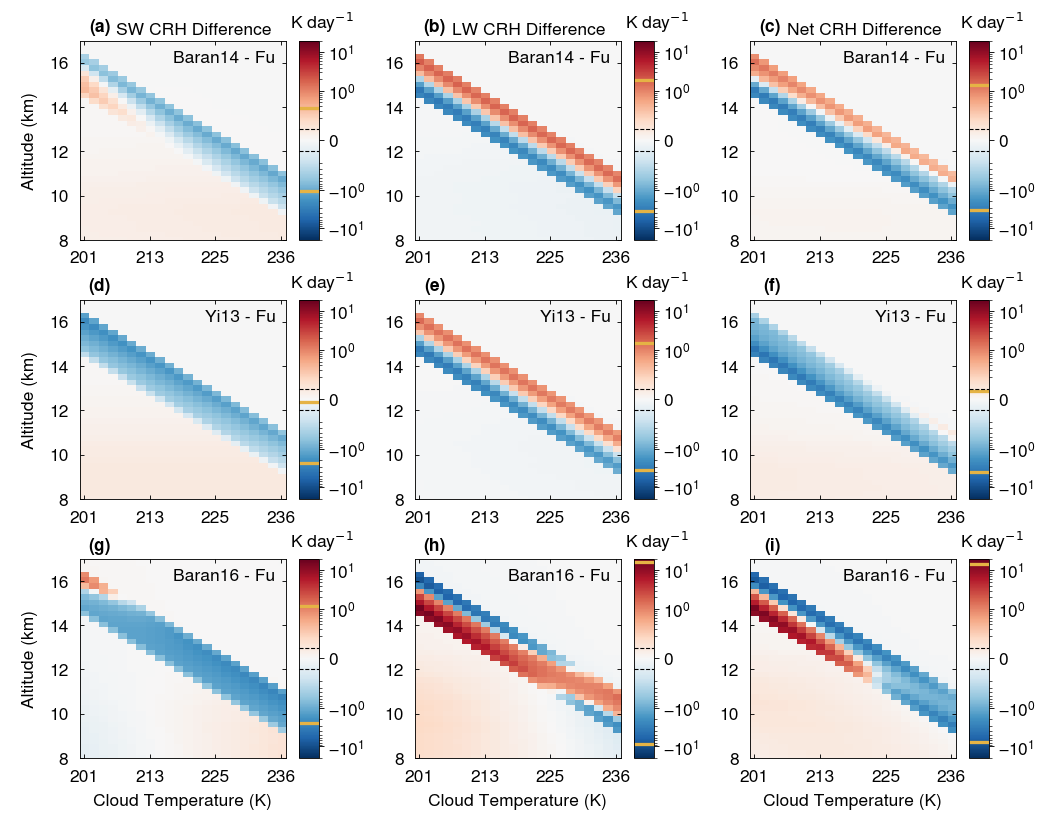

In [19]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.5 # inches
flength  = 13.5 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

labelpad  = -40
IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu

for diff in range(rows): 
    IntSch = IntSch_order[diff]
    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_net_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_net.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff            = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
        ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
plt.savefig(out_dir+'crh_diff_test1_Fu_F2_v6alt.pdf', dpi=500)